In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape, Flatten, ZeroPadding2D, Layer
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from simple_movement import DataGen, SimpleMovement

Using TensorFlow backend.


In [2]:
BASE_PATH = 'C:\\Users\\ttanj\\UoB\\WS18\\DBM\\data\data_simple_movement'
HEIGHT = 100
WIDTH = 100
NUM_CHANNEL = 2
RGB = 0

In [3]:
class MMCLayer(Layer):
    
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MMCLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                     shape=(input_shape[1], self.output_dim),
                                     initializer='uniform',
                                     trainable=True)
        super(MMCLayer, self).build(input_shape)
        
    def call(self, x):
        df = 1 / 5
        w = np.array([
            [1, df, 0], [-1, 0, 1], [0, 0, 1]
        ])
        return K.dot(K.dot(x, self.kernel), K.constant(w))
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [8]:
input_img = Input(shape=(HEIGHT, WIDTH, NUM_CHANNEL))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Reshape((13*13*8,))(x)
x = MMCLayer(3)(x)
x = Dense(13*13*8, activation='relu')(x)
x = Reshape((13, 13, 8))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 2)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 16)      304       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 8)         0         
__________

In [9]:
dgen = DataGen(HEIGHT, WIDTH, NUM_CHANNEL)
x, y = dgen.prepare_data(8)

x = x / 255.
y = y / 255.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True, random_state=331)

autoencoder.fit(x_train, y_train,
                epochs=1000,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 86 samples, validate on 10 samples
Epoch 1/1000
86/86 [==============================] - 4s 41ms/step - loss: 0.6877 - val_loss: 0.6669
Epoch 2/1000
86/86 [==============================] - 3s 31ms/step - loss: 0.5505 - val_loss: 0.2414
Epoch 3/1000
86/86 [==============================] - 3s 31ms/step - loss: 0.2356 - val_loss: 0.2025
Epoch 4/1000
86/86 [==============================] - 3s 31ms/step - loss: 0.1748 - val_loss: 0.1689
Epoch 5/1000
86/86 [==============================] - 3s 32ms/step - loss: 0.1476 - val_loss: 0.1386
Epoch 6/1000
86/86 [==============================] - 3s 33ms/step - loss: 0.1275 - val_loss: 0.1183
Epoch 7/1000
86/86 [==============================] - 3s 32ms/step - loss: 0.1119 - val_loss: 0.1038
Epoch 8/1000
86/86 [==============================] - 3s 33ms/step - loss: 0.0990 - val_loss: 0.0927
Epoch 9/1000
86/86 [==============================] - 3s 34ms/step - loss: 0.0887 - val_loss: 0.0837
Epoch 10/1000
86/86 [==========================

KeyboardInterrupt: 

In [10]:
decoded_imgs = autoencoder.predict(x_test)

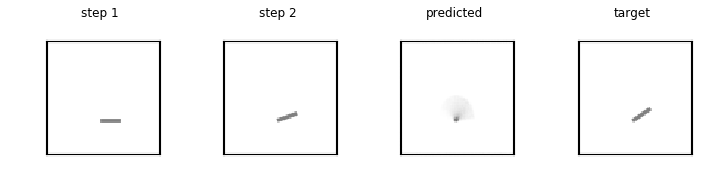

In [11]:
idx = 3

plt.figure(figsize=(10, 3))

# display original
ax = plt.subplot(1, 4, 1)
ax.imshow(x_test[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
ax.axis('off'), ax.set_title('step 1')

ax = plt.subplot(1, 4, 2)
ax.imshow(x_test[idx][:, :, 1].reshape(HEIGHT, WIDTH), cmap='gray')
ax.axis('off'), ax.set_title('step 2')

# display reconstruction
ax = plt.subplot(1, 4, 3)
ax.imshow(decoded_imgs[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
ax.axis('off'), ax.set_title('predicted')

ax = plt.subplot(1, 4, 4)
ax.imshow(y_test[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
ax.axis('off'), ax.set_title('target')

plt.tight_layout()